In [30]:
# ...existing code...
import os
import re
import cv2
import numpy as np
import pandas as pd

def load_chest_xray(base_dir='chest_xray',
                    splits=('train','test','val'),
                    labels=('NORMAL','PNEUMONIA'),
                    target_size=None,    # (width,height) o None para mantener tamaño
                    load_images=True,    # False -> solo metadata y rutas
                    max_per_folder=None  # límite por carpeta (útil para tests)
                   ):
    """
    Devuelve un dict {split: DataFrame} con columnas:
      path, split, label,
      is_virus (bool), is_bacteria (bool), infection_tags (tuple),
      person_id (int|None), image (ndarray|None)

    Nota: no se usa una columna 'infection' con valores exclusivos; se usan
    las columnas booleanas is_virus/is_bacteria. NORMAL -> both False, coinfección -> both True.
    """
    rows_by_split = {s: [] for s in splits}
    person_re = re.compile(r'person(\d+)', re.IGNORECASE)

    for split in splits:
        for label in labels:
            folder = os.path.join(base_dir, split, label)
            if not os.path.isdir(folder):
                continue
            files = [f for f in os.listdir(folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
            if max_per_folder:
                files = files[:max_per_folder]
            for fname in files:
                path = os.path.join(folder, fname)
                image = None
                if load_images:
                    im = cv2.imread(path)
                    if im is None:
                        print(f"Warning: no se pudo leer {path}")
                        continue
                    if len(im.shape) == 3:
                        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                    if target_size:
                        im = cv2.resize(im, target_size, interpolation=cv2.INTER_AREA)
                    image = im

                fn = fname.lower()
                is_virus = 'virus' in fn
                is_bacteria = ('bacteria' in fn) or ('bacterial' in fn)
                infection_tags = tuple(t for t, present in (('virus', is_virus), ('bacteria', is_bacteria)) if present)

                m = person_re.search(fname)
                person_id = int(m.group(1)) if m else None

                rows_by_split[split].append({
                    'path': path,
                    'split': split,
                    'label': label,
                    'is_virus': bool(is_virus),
                    'is_bacteria': bool(is_bacteria),
                    'infection_tags': infection_tags,
                    'person_id': person_id,
                    'image': image
                })

    dfs = {}
    for s, rows in rows_by_split.items():
        if rows:
            df = pd.DataFrame(rows, columns=['path','split','label','is_virus','is_bacteria','infection_tags','person_id','image'])
            dfs[s] = df
            print(f"{s}: leidas {len(df)} imágenes")
            print(df.groupby('label').size())
        else:
            print(f"{s}: carpeta no encontrada o vacía")
            dfs[s] = pd.DataFrame(columns=['path','split','label','is_virus','is_bacteria','infection_tags','person_id','image'])

    return dfs
# ...existing code...

In [31]:
dfs = load_chest_xray(target_size=(224,224), load_images=True)
train_df = dfs.get('train')
test_df  = dfs.get('test')
val_df   = dfs.get('val')

train: leidas 5216 imágenes
label
NORMAL       1341
PNEUMONIA    3875
dtype: int64
test: leidas 624 imágenes
label
NORMAL       234
PNEUMONIA    390
dtype: int64
val: leidas 16 imágenes
label
NORMAL       8
PNEUMONIA    8
dtype: int64


NORMAL — chest_xray\train\NORMAL\NORMAL2-IM-1262-0001.jpeg


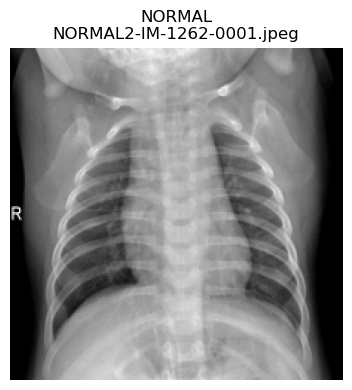

VIRUS only — person80.0 — 1 imágenes


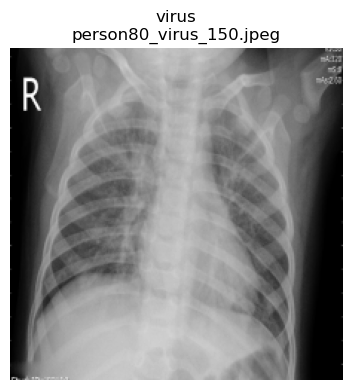

BACTERIA only — person1.0 — 2 imágenes


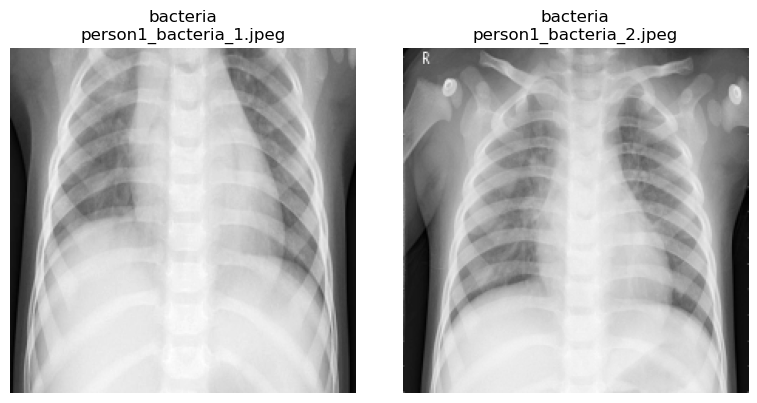

COINFECTION person255.0 — 8 imágenes


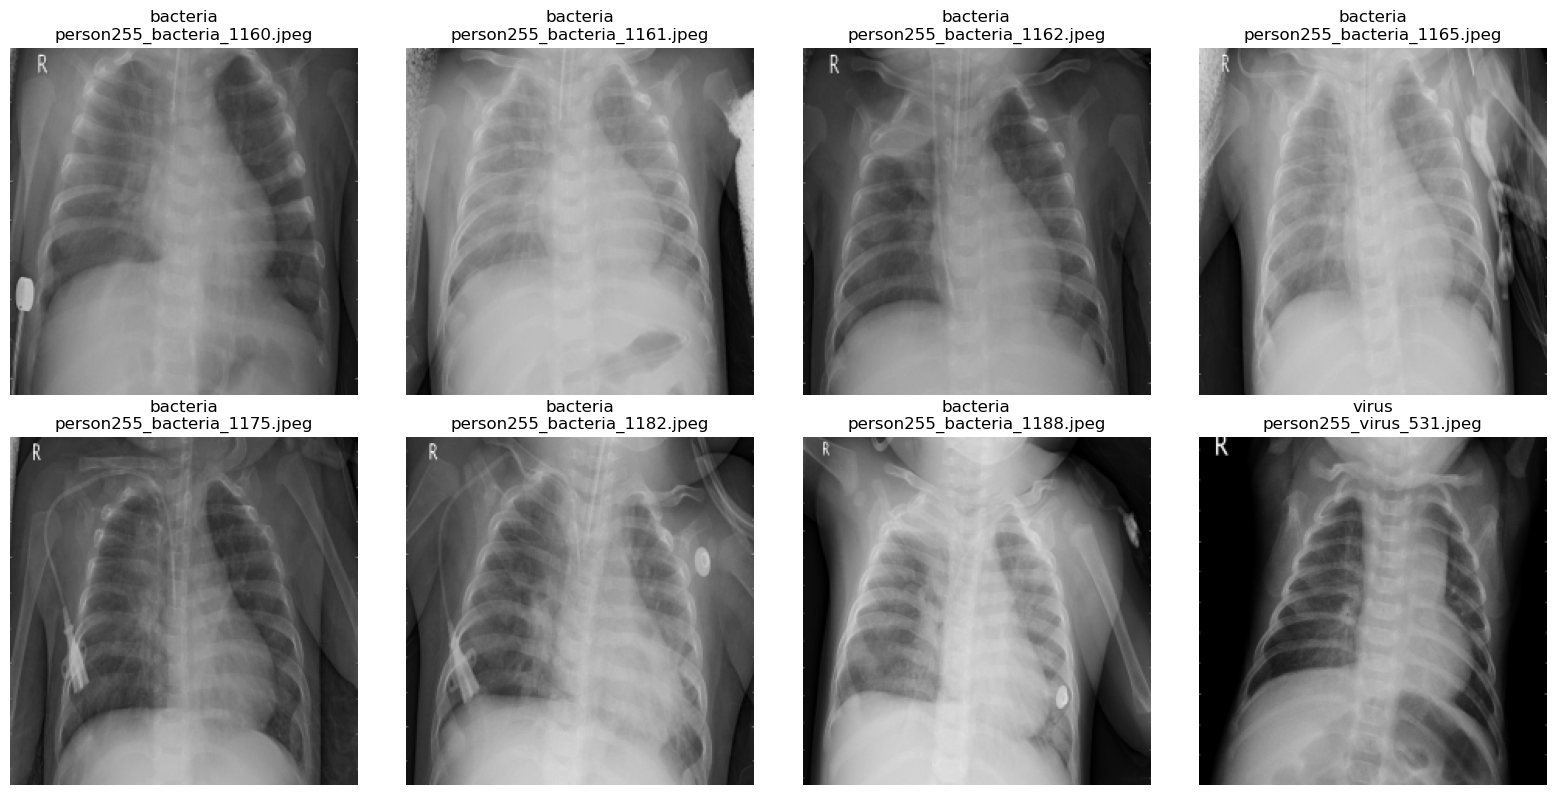

In [32]:
import math

def _load_img_from_row(row):
    if isinstance(row, dict) or isinstance(row, pd.Series):
        if 'image' in row and row['image'] is not None:
            return row['image']
        path = row['path']
    else:
        path = row
    im = cv2.imread(path)
    if im is None:
        raise FileNotFoundError(path)
    if len(im.shape) == 3:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return im

def show_grid(images, titles=None, max_cols=4, cmap='gray', figsize_per_img=(4,4)):
    n = len(images)
    if n == 0:
        print("No hay imágenes para mostrar.")
        return
    cols = min(max_cols, n)
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_img[0]*cols, figsize_per_img[1]*rows))
    axes = np.array(axes).reshape(-1)
    for i, ax in enumerate(axes):
        if i < n:
            im = images[i]
            ax.imshow(im, cmap=cmap)
            if titles and i < len(titles):
                ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

if 'train_df' not in globals() or train_df is None:
    print("train_df no encontrado. Ejecuta la celda que carga el dataset antes.")
else:
    # 1) NORMAL (una aleatoria)
    normals = train_df[train_df['label']=='NORMAL']
    if len(normals):
        s = normals.sample(1).iloc[0]
        print("NORMAL —", s['path'])
        show_grid([_load_img_from_row(s)], [f"NORMAL\n{os.path.basename(s['path'])}"], max_cols=1)
    else:
        print("No hay imágenes NORMAL en train_df.")

    # Agrupar solo PNEUMONIA con person_id para identificar personas puras/mix
    pneu = train_df[(train_df['label']=='PNEUMONIA') & (train_df['person_id'].notnull())]
    if len(pneu):
        grouped = pneu.groupby('person_id').agg(any_virus=('is_virus','any'),
                                                any_bact=('is_bacteria','any'))
    else:
        grouped = pd.DataFrame(columns=['any_virus','any_bact'])

    # VIRUS only: persona con any_virus True y any_bact False
    virus_persons = grouped[(grouped['any_virus']==True) & (grouped['any_bact']==False)].index.tolist()
    if virus_persons:
        pid = virus_persons[0]
        person_rows = train_df[(train_df['person_id']==pid) & (train_df['label']=='PNEUMONIA')].sort_values('path')
        imgs, titles = [], []
        for _, r in person_rows.iterrows():
            imgs.append(_load_img_from_row(r))
            tag = 'virus' if r.get('is_virus', False) else ('bacteria' if r.get('is_bacteria', False) else 'unknown')
            titles.append(f"{tag}\n{os.path.basename(r['path'])}")
        print(f"VIRUS only — person{pid} — {len(imgs)} imágenes")
        show_grid(imgs, titles)
    else:
        print("No se encontró persona con solo imágenes de virus en train_df.")

    # BACTERIA only: persona con any_bact True y any_virus False
    bact_persons = grouped[(grouped['any_bact']==True) & (grouped['any_virus']==False)].index.tolist()
    if bact_persons:
        pid = bact_persons[0]
        person_rows = train_df[(train_df['person_id']==pid) & (train_df['label']=='PNEUMONIA')].sort_values('path')
        imgs, titles = [], []
        for _, r in person_rows.iterrows():
            imgs.append(_load_img_from_row(r))
            tag = 'bacteria' if r.get('is_bacteria', False) else ('virus' if r.get('is_virus', False) else 'unknown')
            titles.append(f"{tag}\n{os.path.basename(r['path'])}")
        print(f"BACTERIA only — person{pid} — {len(imgs)} imágenes")
        show_grid(imgs, titles)
    else:
        print("No se encontró persona con solo imágenes de bacteria en train_df.")

    # BOTH / coinfección: persona con any_virus True y any_bact True
    both_persons = grouped[(grouped['any_virus']==True) & (grouped['any_bact']==True)].index.tolist()
    # además aceptar personas con alguna imagen marcada 'both' si existiera
    if 'infection' in train_df.columns:
        both_alt = train_df[(train_df['label']=='PNEUMONIA') & (train_df['infection']=='both') & (train_df['person_id'].notnull())]['person_id'].unique().tolist()
        # unir manteniendo orden
        for p in both_alt:
            if p not in both_persons:
                both_persons.append(p)
    if both_persons:
        pid = both_persons[0]
        person_rows = train_df[(train_df['person_id']==pid) & (train_df['label']=='PNEUMONIA')].sort_values('path')
        imgs, titles = [], []
        for _, r in person_rows.iterrows():
            imgs.append(_load_img_from_row(r))
            tag = ('both' if ('infection' in r and r['infection']=='both') else
                   ('virus' if r.get('is_virus', False) and not r.get('is_bacteria', False) else
                    ('bacteria' if r.get('is_bacteria', False) and not r.get('is_virus', False) else
                     ('virus+bacteria' if r.get('is_virus', False) and r.get('is_bacteria', False) else 'unknown'))))
            titles.append(f"{tag}\n{os.path.basename(r['path'])}")
        print(f"COINFECTION person{pid} — {len(imgs)} imágenes")
        show_grid(imgs, titles)
    else:
        print("No se encontró persona con coinfección en train_df.")
